# Report on Covid Positive X-Ray Image Data
Github Link: https://github.com/soobino/adv_machine_learning

*   QMSS 5074
*   Advanced Machine Learning 
*  Spring 2023

## Set Up

In [ ]:
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/covid_radiography_data/COVID-19_Radiography_Dataset.zip


In [19]:
# Load libraries

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

from mpl_toolkits.axes_grid1 import ImageGrid
import random

In [20]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-532.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-696.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-146.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3426.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-107.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-367.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3253.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3027.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3484.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3576.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3559.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1019.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-106.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3227.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1955.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID

In [26]:
print(base_path)

COVID-19_Radiography_Dataset


In [22]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img
#pre processing a different way would change results
#use data augmentation / transformation


#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [23]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [6]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


In [8]:
print(fnames[2][1])

COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1138.png


##1. Data Exploration

**Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).**

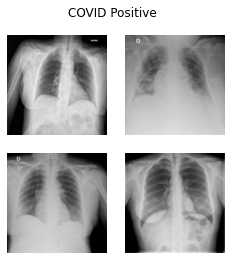

In [32]:
im1 =preprocessor(fnames[0][0]) 
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[0][2]) 
im4 =preprocessor(fnames[0][3]) 

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')
    
fig.suptitle("COVID Positive")
plt.show()

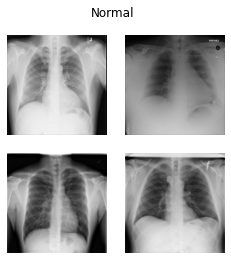

In [33]:
im1 =preprocessor(fnames[1][0]) 
im2 =preprocessor(fnames[1][1])
im3 =preprocessor(fnames[1][2]) 
im4 =preprocessor(fnames[1][3])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')
fig.suptitle("Normal")
plt.show()

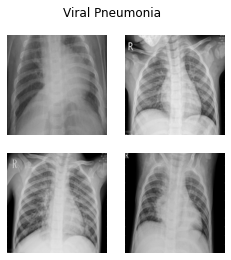

In [35]:
im1 =preprocessor(fnames[2][0]) 
im2 =preprocessor(fnames[2][1])
im3 =preprocessor(fnames[2][2]) 
im4 =preprocessor(fnames[2][3])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')
fig.suptitle("Viral Pneumonia")
plt.show()

**Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.**

The data set has a robust collection of lung images with various conditions. Diagnosis based on X-ray image requires much medical training, which can be a bottleneck in situations like the COVID-19 pandemic when the number of available medical staff was severely lacking compared to the number of patients. Using machine learning models to predict the diagnosis will alleviate the burden of the manual work required by the doctors. The predicted diagnosis can be used to filter through patients with most in need of assistance.

## 2. Prediction Models (Round 1)

In [9]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [10]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [11]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [1]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

**Run at least three prediction models to try to predict x-ray images well.
Use transfer learning for at least one of these models**

In [2]:
#smaller filters 16-32-64

import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model_1.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  model_1.fit(X_train, y_train, 
                    epochs = 2, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/2
69/69 [==============================] - 16s 57ms/step - loss: 0.7044 - accuracy: 0.6752 - val_loss: 0.5374 - val_accuracy: 0.7614
Epoch 2/2
69/69 [==============================] - 3s 46ms/step - loss: 0.4772 - accuracy: 0.7865 - val_loss: 0.4786 - val_accuracy: 0.8160


In [ ]:
#regularization

import tensorflow as tf
from tensorflow.keras import regularizers


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model_2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  model_2.fit(X_train, y_train, 
                    epochs = 2, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/2
68/69 [============================>.] - ETA: 0s - loss: 2.0265 - accuracy: 0.6420

In [ ]:
#with batch normalization

import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_3 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model_3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  model_3.fit(X_train, y_train, 
                    epochs = 2, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

In [ ]:
#with batch normalization + regularization

import tensorflow as tf
from tensorflow.keras import regularizers

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_4 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model_4.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  model_4.fit(X_train, y_train, 
                    epochs = 2, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

In [9]:
#Inception model
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

IMG_SHAPE = (192, 192, 3)

base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False

# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)

# define new model
model_5 = Model(inputs=base_model.inputs, outputs=output)

# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_5.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model_5.fit(X_train, y_train,
          epochs = 2, verbose=1,validation_split=.2)

Epoch 1/2
69/69 [==============================] - 20s 236ms/step - loss: 0.6282 - acc: 0.7203 - val_loss: 0.3745 - val_acc: 0.8379
Epoch 2/2
69/69 [==============================] - 5s 76ms/step - loss: 0.3867 - acc: 0.8403 - val_loss: 0.3290 - val_acc: 0.8743


**Discuss which models performed better and point out relevant hyper-parameter values for successful models.**

With 1 epoch, adding batch normalization and regularization improved the performance compared to the base model. When paired together, the model had the highest accuracy with 0.7550. With 2 epoch, accuracy goes up to 0.9078. Considering that the initial model with the same filter sizes and layers but without the batch normalization and regularization, had accuracy of 0.6437 with 1 epoch and 0.7897 with 2 epoch, we can conclude that the hyper parameters indeed improved the model. 



**Submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.**

In [17]:
model_1.save("model1.h5", save_format="h5")
model_2.save("model2.h5", save_format="h5")
model_3.save("model3.h5", save_format="h5")
model_4.save("model4.h5", save_format="h5")
model_5.save("model5.h5", save_format="h5")

In [7]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [12]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
from aimodelshare.aimsonnx import model_to_onnx
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

for number in range(1, 4):
    object_name = "model_" + str(number)
    h5_name = "model"+ str(number) + ".h5"

    model = tf.keras.models.load_model(h5_name,compile=False)
    model.compile(
        optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
        loss= 'categorical_crossentropy',
        metrics=['accuracy'])

    #model = globals()[object_name]
    
    # Save tf.keras model (or any tensorflow model) to local ONNX file

    onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)
    file_name= object_name+".onnx"
    with open(file_name, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
    prediction_column_index=model.predict(X_test).argmax(axis=1)
    prediction_labels = [y_train.columns[i] for i in prediction_column_index]

    experiment.submit_model(model_filepath = file_name,
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)


In [6]:
#transfer learning = model 5

number = 5

object_name = "model_" + str(number)
h5_name = "model"+ str(number) + ".h5"

model = tf.keras.models.load_model(h5_name,compile=False)
model.compile(
        optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
        loss= 'categorical_crossentropy',
        metrics=['accuracy'])

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)
file_name= object_name+".onnx"

with open(file_name, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
prediction_column_index=model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = file_name,
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 6s 75ms/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 297

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


**After you submit your first three models, describe your best model with your team via your team slack channel.
Fit and submit up to three more models after learning from your team. Discuss results**

My teammates had good performance with VGG format, so I tried using that. I also increased the number of epoch to find the right level to fit the model. I also experimented using SGD and adam optimizer. They had accuracy of 0.95 and 0.93, respectively. Increasing epoch to 5 on the best model from the earlier section, the accuracy went up to 0.99 using the training data.

When submitted to the leaderboard, my best model (Model 299) was the version with VGG with Adam compiler. It had 0.9527 accuracy, 0.9527 in f-1 score, 0.8531 in precision, and 0.8473 in recall. 

In [3]:
# VGG using SGD
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition


base_model.trainable = False

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model_6 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model_6.compile(
    optimizer='sgd',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model_6.fit(X_train, y_train,
          epochs = 2, verbose=1,validation_split=.2)

Epoch 1/2
69/69 [==============================] - 28s 188ms/step - loss: 0.6023 - acc: 0.8043 - val_loss: 0.2085 - val_acc: 0.9199
Epoch 2/2
69/69 [==============================] - 10s 148ms/step - loss: 0.1396 - acc: 0.9516 - val_loss: 0.1717 - val_acc: 0.9399


In [13]:
from aimodelshare.aimsonnx import model_to_onnx
import pickle
  
number = 6

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

object_name = "model_" + str(number)
h5_name = "model"+ str(number) + ".h5"

model = tf.keras.models.load_model(h5_name,compile=False)
model.compile(
        optimizer="sgd", 
        loss= 'categorical_crossentropy',
        metrics=['accuracy'])

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)
file_name= object_name+".onnx"

with open(file_name, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
prediction_column_index=model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = file_name,
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 6s 142ms/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 298

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [5]:
# VGG using adam

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition


base_model.trainable = False

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model_7 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model_7.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model_7.fit(X_train, y_train,
          epochs = 2, verbose=1,validation_split=.2)

Epoch 1/2
69/69 [==============================] - 12s 156ms/step - loss: 0.5470 - acc: 0.7979 - val_loss: 0.2211 - val_acc: 0.9144
Epoch 2/2
69/69 [==============================] - 10s 149ms/step - loss: 0.1808 - acc: 0.9320 - val_loss: 0.1699 - val_acc: 0.9399


In [14]:
from aimodelshare.aimsonnx import model_to_onnx
import pickle
  
number = 7

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

object_name = "model_" + str(number)
h5_name = "model"+ str(number) + ".h5"

model = tf.keras.models.load_model(h5_name,compile=False)
model.compile(
        optimizer="adam", 
        loss= 'categorical_crossentropy',
        metrics=['accuracy'])

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)
file_name= object_name+".onnx"

with open(file_name, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
prediction_column_index=model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = file_name,
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 5s 113ms/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 299

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [7]:
#with batch normalization + regularization + 5 epoch

import tensorflow as tf
from tensorflow.keras import regularizers

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_8 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model_8.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  model_8.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
69/69 [==============================] - 7s 76ms/step - loss: 3.1434 - accuracy: 0.7158 - val_loss: 2.6501 - val_accuracy: 0.6102
Epoch 2/5
69/69 [==============================] - 3s 49ms/step - loss: 1.7703 - accuracy: 0.9051 - val_loss: 2.5521 - val_accuracy: 0.4991
Epoch 3/5
69/69 [==============================] - 3s 48ms/step - loss: 1.5189 - accuracy: 0.9494 - val_loss: 2.6008 - val_accuracy: 0.3206
Epoch 4/5
69/69 [==============================] - 3s 45ms/step - loss: 1.3490 - accuracy: 0.9685 - val_loss: 2.2484 - val_accuracy: 0.4335
Epoch 5/5
69/69 [==============================] - 3s 46ms/step - loss: 1.1797 - accuracy: 0.9913 - val_loss: 1.9452 - val_accuracy: 0.5665


In [15]:
from aimodelshare.aimsonnx import model_to_onnx
import pickle
  
number = 8

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

object_name = "model_" + str(number)
h5_name = "model"+ str(number) + ".h5"

model = tf.keras.models.load_model(h5_name,compile=False)
model.compile(
        optimizer="adam", 
        loss= 'categorical_crossentropy',
        metrics=['accuracy'])

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)
file_name= object_name+".onnx"

with open(file_name, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
prediction_column_index=model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = file_name,
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 1s 19ms/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 300

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [8]:
model_6.save("model6.h5", save_format="h5")
model_7.save("model7.h5", save_format="h5")
model_8.save("model8.h5", save_format="h5")

**Try to use augmented data to rerun at least one model and submit it to the leaderboard.**

Running augmented data, the accuracy of the model is generally lower than the initial models. 

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

batch_size = 128
epochs = 5
IMG_HEIGHT = 192
IMG_WIDTH = 192


Found 42330 images belonging to 4 classes.


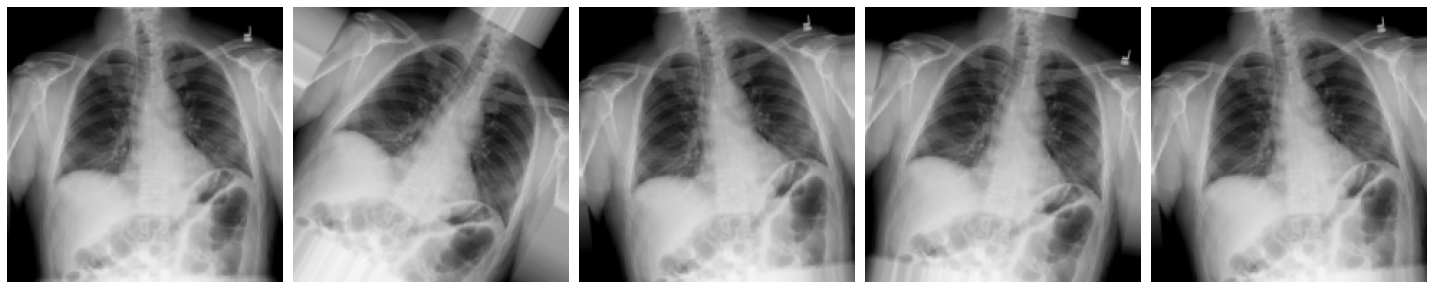

In [41]:
#rotation
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=base_path,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images) 

Found 42330 images belonging to 4 classes.


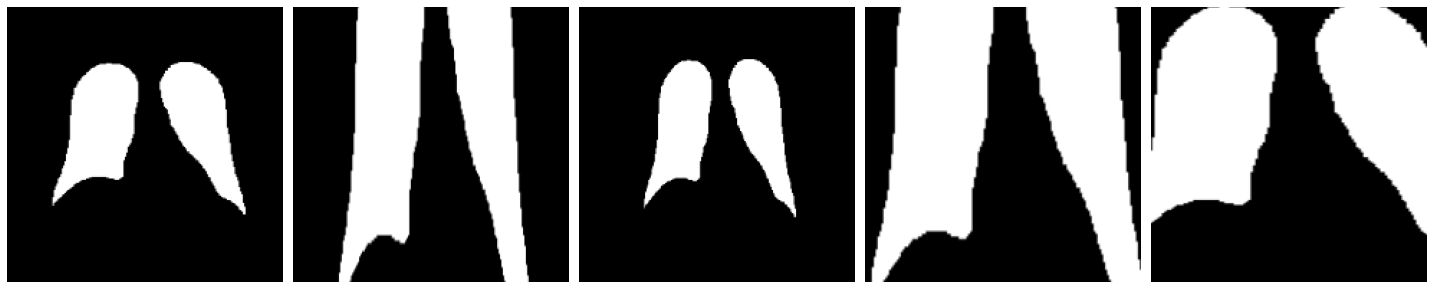

In [40]:
#zoom
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=base_path,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images) 

In [7]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

training_generator = datagen.flow(X_train, y_train, batch_size=64,subset='training',seed=7)
validation_generator = datagen.flow(X_train, y_train, batch_size=64,subset='validation',seed=7)

In [8]:
#use model 1 as base
model_1_a = tf.keras.models.load_model('model1.h5',compile=False)
model_1_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
model_1_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)

#use model 2 as base
model_2_a = tf.keras.models.load_model('model2.h5',compile=False)
model_2_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
model_2_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)

#use model 3 as base
model_3_a = tf.keras.models.load_model('model3.h5',compile=False)
model_3_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
model_3_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)

#use model 4 as base
model_4_a = tf.keras.models.load_model('model4.h5',compile=False)
model_4_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
model_4_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)

#use model 5 as base
model_5_a = tf.keras.models.load_model('model5.h5',compile=False)
model_5_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
model_5_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)

#use model 6 as base
model_6_a = tf.keras.models.load_model('model6.h5',compile=False)
model_6_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
model_6_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


#use model 7 as base
model_7_a = tf.keras.models.load_model('model7.h5',compile=False)
model_7_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
model_7_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)

#use model 8 as base
model_8_a = tf.keras.models.load_model('model8.h5',compile=False)
model_8_a.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
model_8_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


Epoch 1/10


<ipython-input-8-7c03910d2119>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_1_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


34/34 [==============================] - 4s 98ms/step - loss: 1.1487 - acc: 0.3368 - val_loss: 1.0939 - val_acc: 0.3301
Epoch 2/10
34/34 [==============================] - 3s 79ms/step - loss: 1.0591 - acc: 0.4641 - val_loss: 0.9125 - val_acc: 0.6836
Epoch 3/10
34/34 [==============================] - 3s 78ms/step - loss: 0.6872 - acc: 0.7154 - val_loss: 0.5888 - val_acc: 0.7246
Epoch 4/10
34/34 [==============================] - 3s 82ms/step - loss: 0.5544 - acc: 0.7539 - val_loss: 0.4848 - val_acc: 0.7871
Epoch 5/10
34/34 [==============================] - 3s 86ms/step - loss: 0.4926 - acc: 0.7877 - val_loss: 0.4373 - val_acc: 0.7988
Epoch 6/10
34/34 [==============================] - 3s 86ms/step - loss: 0.4631 - acc: 0.7839 - val_loss: 0.4061 - val_acc: 0.8301
Epoch 7/10
34/34 [==============================] - 3s 95ms/step - loss: 0.4517 - acc: 0.8041 - val_loss: 0.4472 - val_acc: 0.8066
Epoch 8/10
34/34 [==============================] - 3s 86ms/step - loss: 0.4307 - acc: 0.8023 

<ipython-input-8-7c03910d2119>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_2_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


34/34 [==============================] - 4s 93ms/step - loss: 1.5597 - acc: 0.3429 - val_loss: 1.3681 - val_acc: 0.3242
Epoch 2/10
34/34 [==============================] - 3s 81ms/step - loss: 1.3053 - acc: 0.3095 - val_loss: 1.2541 - val_acc: 0.3164
Epoch 3/10
34/34 [==============================] - 3s 81ms/step - loss: 1.2218 - acc: 0.3189 - val_loss: 1.1960 - val_acc: 0.3184
Epoch 4/10
34/34 [==============================] - 3s 79ms/step - loss: 1.1772 - acc: 0.3358 - val_loss: 1.1613 - val_acc: 0.3262
Epoch 5/10
34/34 [==============================] - 3s 93ms/step - loss: 1.1511 - acc: 0.3344 - val_loss: 1.1415 - val_acc: 0.3496
Epoch 6/10
34/34 [==============================] - 3s 81ms/step - loss: 1.1364 - acc: 0.3415 - val_loss: 1.1307 - val_acc: 0.3242
Epoch 7/10
34/34 [==============================] - 3s 80ms/step - loss: 1.1253 - acc: 0.2997 - val_loss: 1.1198 - val_acc: 0.3125
Epoch 8/10
34/34 [==============================] - 3s 79ms/step - loss: 1.1169 - acc: 0.3382 

<ipython-input-8-7c03910d2119>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_3_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


34/34 [==============================] - 6s 129ms/step - loss: 0.5270 - acc: 0.7590 - val_loss: 1.6881 - val_acc: 0.3516
Epoch 2/10
34/34 [==============================] - 3s 88ms/step - loss: 0.3141 - acc: 0.8610 - val_loss: 1.3926 - val_acc: 0.3398
Epoch 3/10
34/34 [==============================] - 3s 93ms/step - loss: 0.2275 - acc: 0.9084 - val_loss: 1.9114 - val_acc: 0.3555
Epoch 4/10
34/34 [==============================] - 3s 94ms/step - loss: 0.1485 - acc: 0.9399 - val_loss: 1.2573 - val_acc: 0.3516
Epoch 5/10
34/34 [==============================] - 3s 101ms/step - loss: 0.0953 - acc: 0.9638 - val_loss: 1.2390 - val_acc: 0.3516
Epoch 6/10
34/34 [==============================] - 3s 90ms/step - loss: 0.0642 - acc: 0.9770 - val_loss: 1.1213 - val_acc: 0.4121
Epoch 7/10
34/34 [==============================] - 3s 88ms/step - loss: 0.0411 - acc: 0.9864 - val_loss: 1.0651 - val_acc: 0.3867
Epoch 8/10
34/34 [==============================] - 3s 96ms/step - loss: 0.0263 - acc: 0.993

<ipython-input-8-7c03910d2119>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_4_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


34/34 [==============================] - 4s 99ms/step - loss: 1.7703 - acc: 0.7201 - val_loss: 2.0613 - val_acc: 0.3555
Epoch 2/10
34/34 [==============================] - 4s 109ms/step - loss: 1.2372 - acc: 0.8176 - val_loss: 1.9209 - val_acc: 0.3438
Epoch 3/10
34/34 [==============================] - 4s 110ms/step - loss: 0.9485 - acc: 0.8455 - val_loss: 1.7631 - val_acc: 0.3438
Epoch 4/10
34/34 [==============================] - 3s 100ms/step - loss: 0.7841 - acc: 0.8591 - val_loss: 1.6628 - val_acc: 0.3457
Epoch 5/10
34/34 [==============================] - 3s 91ms/step - loss: 0.6713 - acc: 0.8732 - val_loss: 1.4952 - val_acc: 0.3379
Epoch 6/10
34/34 [==============================] - 3s 93ms/step - loss: 0.5492 - acc: 0.8995 - val_loss: 1.3727 - val_acc: 0.3535
Epoch 7/10
34/34 [==============================] - 3s 99ms/step - loss: 0.4512 - acc: 0.9295 - val_loss: 1.3397 - val_acc: 0.3477
Epoch 8/10
34/34 [==============================] - 3s 95ms/step - loss: 0.4073 - acc: 0.93

<ipython-input-8-7c03910d2119>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_5_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


34/34 [==============================] - 14s 217ms/step - loss: 1.0741 - acc: 0.4270 - val_loss: 1.0801 - val_acc: 0.3223
Epoch 2/10
34/34 [==============================] - 5s 135ms/step - loss: 1.0249 - acc: 0.4791 - val_loss: 1.0008 - val_acc: 0.6523
Epoch 3/10
34/34 [==============================] - 5s 132ms/step - loss: 0.9744 - acc: 0.6590 - val_loss: 0.9668 - val_acc: 0.6309
Epoch 4/10
34/34 [==============================] - 5s 135ms/step - loss: 0.9381 - acc: 0.6956 - val_loss: 0.9283 - val_acc: 0.7012
Epoch 5/10
34/34 [==============================] - 4s 130ms/step - loss: 0.9044 - acc: 0.6928 - val_loss: 0.9063 - val_acc: 0.7129
Epoch 6/10
34/34 [==============================] - 4s 129ms/step - loss: 0.8747 - acc: 0.7111 - val_loss: 0.8808 - val_acc: 0.7051
Epoch 7/10
34/34 [==============================] - 5s 132ms/step - loss: 0.8468 - acc: 0.7191 - val_loss: 0.8519 - val_acc: 0.7031
Epoch 8/10
34/34 [==============================] - 5s 135ms/step - loss: 0.8234 - acc

<ipython-input-8-7c03910d2119>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_6_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


34/34 [==============================] - 10s 292ms/step - loss: 1.4909 - acc: 0.3105 - val_loss: 1.1149 - val_acc: 0.3242
Epoch 2/10
34/34 [==============================] - 9s 272ms/step - loss: 1.1039 - acc: 0.3429 - val_loss: 1.0973 - val_acc: 0.3594
Epoch 3/10
34/34 [==============================] - 9s 275ms/step - loss: 1.1002 - acc: 0.3264 - val_loss: 1.1015 - val_acc: 0.3223
Epoch 4/10
34/34 [==============================] - 9s 273ms/step - loss: 1.1012 - acc: 0.3377 - val_loss: 1.0979 - val_acc: 0.3594
Epoch 5/10
34/34 [==============================] - 9s 276ms/step - loss: 1.1036 - acc: 0.3091 - val_loss: 1.0988 - val_acc: 0.3281
Epoch 6/10
34/34 [==============================] - 9s 276ms/step - loss: 1.0987 - acc: 0.3307 - val_loss: 1.0987 - val_acc: 0.3301
Epoch 7/10
34/34 [==============================] - 9s 277ms/step - loss: 1.0987 - acc: 0.3330 - val_loss: 1.0986 - val_acc: 0.3340
Epoch 8/10
34/34 [==============================] - 9s 278ms/step - loss: 1.0986 - acc

<ipython-input-8-7c03910d2119>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_7_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


34/34 [==============================] - 11s 291ms/step - loss: 1.5573 - acc: 0.3119 - val_loss: 1.1158 - val_acc: 0.3164
Epoch 2/10
34/34 [==============================] - 9s 274ms/step - loss: 1.1329 - acc: 0.3387 - val_loss: 1.0987 - val_acc: 0.3379
Epoch 3/10
34/34 [==============================] - 9s 276ms/step - loss: 1.1405 - acc: 0.3100 - val_loss: 1.1857 - val_acc: 0.3379
Epoch 4/10
34/34 [==============================] - 9s 273ms/step - loss: 1.1546 - acc: 0.3354 - val_loss: 1.1186 - val_acc: 0.3574
Epoch 5/10
34/34 [==============================] - 9s 277ms/step - loss: 1.1585 - acc: 0.3542 - val_loss: 1.1157 - val_acc: 0.3281
Epoch 6/10
34/34 [==============================] - 9s 273ms/step - loss: 1.1094 - acc: 0.3560 - val_loss: 1.1157 - val_acc: 0.3164
Epoch 7/10
34/34 [==============================] - 9s 277ms/step - loss: 1.1231 - acc: 0.3387 - val_loss: 1.2541 - val_acc: 0.3203
Epoch 8/10
34/34 [==============================] - 9s 273ms/step - loss: 1.1559 - acc

<ipython-input-8-7c03910d2119>:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_8_a.fit_generator(training_generator,steps_per_epoch=(len(X_train)*0.8)//64, epochs=10, validation_data=validation_generator, validation_steps=(len(X_train)*0.2)//64)


34/34 [==============================] - 5s 111ms/step - loss: 1.5116 - acc: 0.6872 - val_loss: 3.8192 - val_acc: 0.3535
Epoch 2/10
34/34 [==============================] - 3s 100ms/step - loss: 1.0324 - acc: 0.7783 - val_loss: 5.8502 - val_acc: 0.3535
Epoch 3/10
34/34 [==============================] - 3s 90ms/step - loss: 0.8036 - acc: 0.8229 - val_loss: 6.0864 - val_acc: 0.3574
Epoch 4/10
34/34 [==============================] - 3s 101ms/step - loss: 0.6670 - acc: 0.8525 - val_loss: 5.4586 - val_acc: 0.3594
Epoch 5/10
34/34 [==============================] - 4s 102ms/step - loss: 0.5920 - acc: 0.8511 - val_loss: 4.1887 - val_acc: 0.3594
Epoch 6/10
34/34 [==============================] - 4s 100ms/step - loss: 0.4910 - acc: 0.8948 - val_loss: 1.7802 - val_acc: 0.3516
Epoch 7/10
34/34 [==============================] - 3s 99ms/step - loss: 0.4478 - acc: 0.9000 - val_loss: 3.1016 - val_acc: 0.3340
Epoch 8/10
34/34 [==============================] - 4s 104ms/step - loss: 0.4023 - acc: 0

In [13]:
from aimodelshare.aimsonnx import model_to_onnx
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

model = model_3_a
model.compile(
        optimizer="adam", 
        loss= 'categorical_crossentropy',
        metrics=['accuracy'])

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)
file_name= str(model)+".onnx"

with open(file_name, "wb") as f:
        f.write(onnx_model.SerializeToString())
    
prediction_column_index=model.predict(X_test).argmax(axis=1)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

experiment.submit_model(model_filepath = file_name,
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 2s 19ms/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): augmented
Provide any useful notes about your model (optional): augmented

Your model has been submitted as model version 306

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


**Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.**

Overall, I tried various models which included batch normalization, regularization, inception model, and VGG16 model and using different compilers. The VGG16 models were generally high performing, and batch normalization also positively impacted the base model in terms of accuracy. 